In [1]:
import os
from glob import glob

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

import numpy as np
from PIL import Image

# Hyperparameter

In [2]:
seed = 1

IMG_HEIGHT = 128
IMG_WIDTH = 128

lr = 0.001

epochs = 30
log_interval = 2

no_cuda = False

use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print('Num_GPU :', torch.cuda.device_count())
batch_size = 128 * torch.cuda.device_count()
test_batch_size = 128 * torch.cuda.device_count()

torch.manual_seed(seed)

kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

Num_GPU : 2


# Model

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #f1
        self.conv1 = nn.Conv2d(3, 64, 5, 2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(3, 64, 5, 2, 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.LeakyReLU(inplace=True)

        self.pool1 = nn.MaxPool2d(2,2,ceil_mode=True)
        
        #f2
        self.conv3 = nn.Conv2d(128, 128, 5, 1, 2)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.LeakyReLU(inplace=True)

        self.conv4 = nn.Conv2d(128, 128, 5, 1, 2)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.LeakyReLU(inplace=True)

        self.pool2 = nn.MaxPool2d(2,2,ceil_mode=True)        
        
        #f3
        self.conv5 = nn.Conv2d(256, 128, 5, 1, 2)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.LeakyReLU(inplace=True)

        self.conv6 = nn.Conv2d(256, 128, 5, 1, 2)
        self.bn6 = nn.BatchNorm2d(128)
        self.relu6 = nn.LeakyReLU(inplace=True)

        self.pool3 = nn.MaxPool2d(2,2,ceil_mode=True)
        
        #f4
        self.conv7 = nn.Conv2d(256, 256, 5, 1, 2)
        self.bn7 = nn.BatchNorm2d(256)
        self.relu7 = nn.LeakyReLU(inplace=True)

        self.conv8 = nn.Conv2d(256, 256, 5, 1, 2)
        self.bn8 = nn.BatchNorm2d(256)
        self.relu8 = nn.LeakyReLU(inplace=True)
       
        #encode
        self.fc1 = nn.Linear(int(IMG_HEIGHT/16)*int(IMG_WIDTH/16)*512, 256)
        self.fc2 = nn.Linear(256,int(IMG_HEIGHT/16)*int(IMG_WIDTH/16)*256)
        
        #d1
        self.conv9 = nn.ConvTranspose2d(256, 128, 5, 2, 2, 1)
        self.bn9 = nn.BatchNorm2d(128)
        self.relu9 = nn.LeakyReLU(inplace=True)
        
        #d1_uni
        self.conv10 = nn.ConvTranspose2d(256, 256, 5, 1, 2)
        self.bn10 = nn.BatchNorm2d(256)
        self.relu10 = nn.LeakyReLU(inplace=True)
        
        #d2
        self.conv11 = nn.ConvTranspose2d(256, 128, 5, 2, 2, 1)
        self.bn11 = nn.BatchNorm2d(128)
        self.relu11 = nn.LeakyReLU(inplace=True)       

        #d2_uni
        self.conv12 = nn.Conv2d(256, 256, 5, 1, 2)
        self.bn12 = nn.BatchNorm2d(256)
        self.relu12 = nn.LeakyReLU(inplace=True)  

        #d3
        self.conv13 = nn.ConvTranspose2d(256, 64, 5, 2, 2, 1)
        self.bn13 = nn.BatchNorm2d(64)
        self.relu13 = nn.LeakyReLU(inplace=True)          

        #d3_uni
        self.conv14 = nn.Conv2d(128, 128, 5, 1, 2)
        self.bn14 = nn.BatchNorm2d(128)
        self.relu14 = nn.LeakyReLU(inplace=True) 
        
        #decode
        self.conv15 = nn.ConvTranspose2d(128, 3, 5, 2, 2, 1)
        
    def forward(self, x):
        f1_1 = self.relu1(self.bn1(self.conv1(x)))
        f1_2 = self.relu2(self.bn2(self.conv2(x)))
        
        f1 = torch.cat((f1_1, f1_2), 1)
        f1 = self.pool1(f1)
        
        f2_1 = self.relu3(self.bn3(self.conv3(f1)))
        f2_2 = self.relu4(self.bn4(self.conv4(f1)))
        
        f2 = torch.cat((f2_1, f2_2), 1)
        f2 = self.pool2(f2)
        
        f3_1 = self.relu5(self.bn5(self.conv5(f2)))
        f3_2 = self.relu6(self.bn6(self.conv6(f2)))
        
        f3 = torch.cat((f3_1, f3_2), 1)
        f3 = self.pool3(f3)

        f4_1 = self.relu7(self.bn7(self.conv7(f3)))
        f4_2 = self.relu8(self.bn8(self.conv8(f3)))
        
        f4 = torch.cat((f4_1, f4_2), 1)

        x = f4.view(f4.size(0), -1)
        encode = self.fc1(x)
        
        d1 = self.fc2(encode)
        d1 = self.relu9(self.bn9(self.conv9(d1.view(-1,256,int(IMG_HEIGHT/16),int(IMG_WIDTH/16)))))
             
        d1_uni = torch.cat((d1, f3_2), 1)
        d1_uni = self.relu10(self.bn10(self.conv10(d1_uni)))
        
        d2 = self.relu11(self.bn11(self.conv11(d1_uni)))
        
        d2_uni = torch.cat((d2, f2_2), 1)
        d2_uni = self.relu12(self.bn12(self.conv12(d2_uni)))
        
        d3 = self.relu13(self.bn13(self.conv13(d2_uni)))
        
        d3_uni = torch.cat((d3, f1_2), 1)
        d3_uni = self.relu14(self.bn14(self.conv14(d3_uni)))

        decode = self.conv15(d3_uni)
        
        return torch.sigmoid(decode)

# Preprocess

In [4]:
train_paths = glob('C:/Users/IVCL/Desktop/duck/no_circle/train/image/*.png')
test_paths = glob('C:/Users/IVCL/Desktop/duck/real/test/image/*.png')
val_paths = glob('C:/Users/IVCL/Desktop/duck/real/val/image/*.png')
len(train_paths), len(test_paths), len(val_paths)

(20000, 253, 1000)

In [5]:
def get_label(path):
    label_path = path[:-20]+'rec/'+path[-14:]
    label = Image.open(label_path).convert("RGB")
    label = np.array(label)
    #label = np.where(label>0,1.0,0)
    label = torch.from_numpy(label/255)
    label = label.view(3,IMG_HEIGHT,IMG_WIDTH)
    
    return label.float()

In [6]:
class Dataset(Dataset):
    def __init__(self, data_paths, transform=None):

        self.data_paths = data_paths
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        path = self.data_paths[idx]
        # Read Image
        image = Image.open(path).convert("RGB")
        
        #Get Label
        label = get_label(path)
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
train_loader = torch.utils.data.DataLoader(
    Dataset(train_paths, 
            transforms.Compose([
                #transforms.RandomHorizontalFlip(), 
                transforms.ToTensor(), 
                transforms.Normalize(
                    mean=[0.406, 0.406, 0.406], 
                    std=[0.225, 0.225, 0.225])])
           ),
    batch_size=batch_size, 
    shuffle=True, 
    **kwargs
)

val_loader = torch.utils.data.DataLoader(
    Dataset(val_paths,
           transforms.Compose([
               transforms.ToTensor(), 
               transforms.Normalize(
                   mean=[0.406, 0.406, 0.406], 
                   std=[0.225, 0.225, 0.225])])
           ),
    batch_size=test_batch_size, 
    shuffle=False, 
    **kwargs
)

test_loader = torch.utils.data.DataLoader(
    Dataset(test_paths,
           transforms.Compose([
               transforms.ToTensor(), 
               transforms.Normalize(
                   mean=[0.406, 0.406, 0.406], 
                   std=[0.225, 0.225, 0.225])])
           ),
    batch_size=test_batch_size, 
    shuffle=False, 
    **kwargs
)

In [8]:
for i, (data, target) in enumerate(train_loader):
    if i == 0:
        print(data[0].shape, target[0].shape)
        label = target[0]
        label = label.view(IMG_HEIGHT,IMG_WIDTH, 3)
        break

torch.Size([3, 128, 128]) torch.Size([3, 128, 128])


# Optimization

In [9]:
model = Net()
model = nn.DataParallel(model)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           4,864
       BatchNorm2d-2           [-1, 64, 64, 64]             128
         LeakyReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]           4,864
       BatchNorm2d-5           [-1, 64, 64, 64]             128
         LeakyReLU-6           [-1, 64, 64, 64]               0
         MaxPool2d-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         409,728
       BatchNorm2d-9          [-1, 128, 32, 32]             256
        LeakyReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         409,728
      BatchNorm2d-12          [-1, 128, 32, 32]             256
        LeakyReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 256,

# Visualization

In [11]:
def visualization(model, test_path, target_path):
    model.eval()
    model.to(device)
    transform = transforms.Compose([
                   transforms.ToTensor(), 
                   transforms.Normalize(
                       mean=[0.406, 0.406, 0.406], 
                       std=[0.225, 0.225, 0.225])])

    image = Image.open(test_path).convert("RGB")
    image = transform(image).view(1,3,IMG_HEIGHT,IMG_WIDTH)
    result = model(image)
    result = result.to('cpu').detach().numpy()
    #result = np.where(result[0,:,:,:]>=0.5, 1.0, 0)

    test_image = plt.imread(test_path)
    target_image = plt.imread(target_path)
    
    plt.figure(figsize=(15,15))
    display_list = [test_image, target_image, result[0,:,:,:].reshape((128,128,3))]
    title = ['Input Image', 'Ground Truth', 'Predicted']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

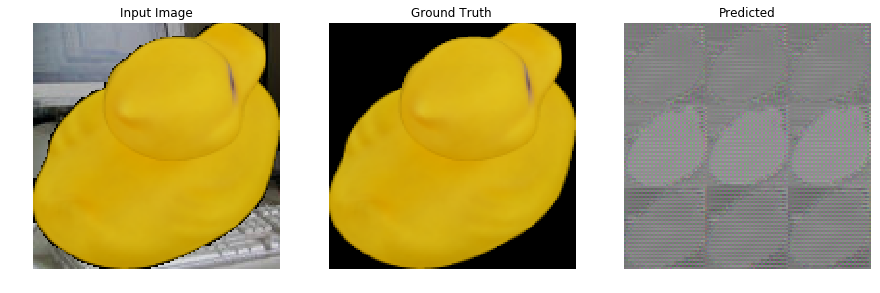

In [12]:
test_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/image/duck_00001.png'
target_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/rec/duck_00001.png'
visualization(model, test_path, target_path)

# Training

In [13]:
checkpoint_path = './checkpoints_tc120_lm_no_circle_rec'

In [16]:
loss_list = []
val_loss_list = []

for epoch in range(1, epochs + 1):
    # Train Mode
    model.to(device).train()

    train_loss_sum = 0
    val_loss_sum = 0 
    
    cut_num = 10 # 1 epoch당 train할 batch_idx (256 * 10 = 2560)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        

        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss_sum = train_loss_sum + loss.item()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), cut_num * batch_size,
                100. * batch_idx * len(data) / (cut_num * batch_size), train_loss_sum / ((batch_idx + 1e-7) * len(data))))
            
        if batch_idx == cut_num:
            break
    
    # Test mode
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.mse_loss(output, target).item()
            
            val_loss_sum = val_loss_sum + val_loss

    loss_list.append(train_loss_sum / len(train_loader.dataset))
    val_loss_list.append(val_loss_sum / len(val_loader.dataset))   
    
    print('\nValidation set: Average loss: {:.6f}'.format(
        val_loss_sum / len(val_loader.dataset)))
    
    if epoch % 2 == 0:
        torch.save(model.state_dict(), checkpoint_path+'/epoch-%s.pt'%epoch)

C:\Users\IVCL\Miniconda3\envs\tc120\lib\site-packages\torch\cuda\nccl.py:24: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Train Epoch: 1 [0/2560 (0%)]	Loss: 7739.001885
Train Epoch: 1 [512/2560 (20%)]	Loss: 0.001029
Train Epoch: 1 [1024/2560 (40%)]	Loss: 0.000807
Train Epoch: 1 [1536/2560 (60%)]	Loss: 0.000725
Train Epoch: 1 [2048/2560 (80%)]	Loss: 0.000684
Train Epoch: 1 [2560/2560 (100%)]	Loss: 0.000658

Validation set: Average loss: 0.001356
Train Epoch: 2 [0/2560 (0%)]	Loss: 5421.044189
Train Epoch: 2 [512/2560 (20%)]	Loss: 0.000817
Train Epoch: 2 [1024/2560 (40%)]	Loss: 0.000674
Train Epoch: 2 [1536/2560 (60%)]	Loss: 0.000625
Train Epoch: 2 [2048/2560 (80%)]	Loss: 0.000600
Train Epoch: 2 [2560/2560 (100%)]	Loss: 0.000585

Validation set: Average loss: 0.000956
Train Epoch: 3 [0/2560 (0%)]	Loss: 5112.077924
Train Epoch: 3 [512/2560 (20%)]	Loss: 0.000776
Train Epoch: 3 [1024/2560 (40%)]	Loss: 0.000645
Train Epoch: 3 [1536/2560 (60%)]	Loss: 0.000601
Train Epoch: 3 [2048/2560 (80%)]	Loss: 0.000579
Train Epoch: 3 [2560/2560 (100%)]	Loss: 0.000565

Validation set: Average loss: 0.000927
Train Epoch: 4 [0/2

# Loss Curve

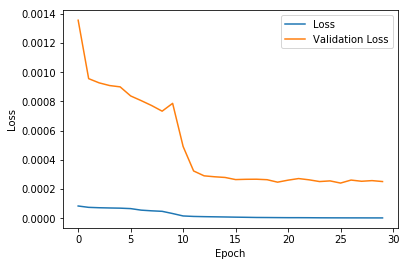

In [17]:
plt.plot(loss_list, label='Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Restore Checkpoint

In [25]:
weight_dict = torch.load(checkpoint_path+'/epoch-30.pt')

In [26]:
model.load_state_dict(weight_dict)

<All keys matched successfully>

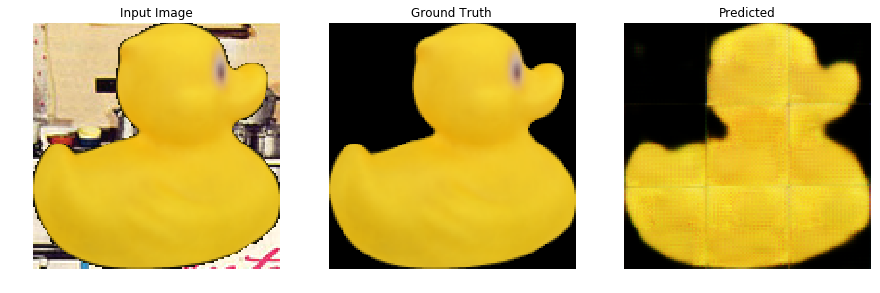

In [28]:
test_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/image/duck_00026.png'
target_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/rec/duck_00026.png'
visualization(model, test_path, target_path)

In [ ]:
i = 0
for path in test_paths:
    label_path = path[:-20]+'rec/'+path[-14:]
    i = i+1
    print('num_image :',i)
    visualization(model, path, label_path)